In [7]:
import networkx as nx
import random
import pickle


# ----------------------------------------------------------
# Helper: add KEGG-like motifs (feed-forward loop, cycle)
# ----------------------------------------------------------
def add_kegg_motifs(G, num_motifs=6):
    for _ in range(num_motifs):
        if len(G.nodes) < 4:
            continue
        a, b, c = random.sample(list(G.nodes), 3)

        # feed-forward loop
        G.add_edge(a, b)
        G.add_edge(b, c)
        G.add_edge(a, c)

        # small cycle
        if random.random() < 0.5:
            d = random.choice(list(G.nodes))
            G.add_edge(c, d)
            G.add_edge(d, a)
    return G

import numpy as np

def sample_kegg_sized_nodes(min_nodes=22, max_nodes=400):
    # lognormal with realistic KEGG parameters
    x = int(np.random.lognormal(mean=3.6, sigma=0.55))
    # clamp to range
    return max(min_nodes, min(x, max_nodes))


# ----------------------------------------------------------
# Helper: add modular structure
# ----------------------------------------------------------
def make_modular(G, num_modules=3):
    nodes = list(G.nodes)
    random.shuffle(nodes)

    module_size = max(3, len(nodes) // num_modules)
    modules = [nodes[i:i+module_size] for i in range(0, len(nodes), module_size)]

    # add sparse inter-module edges
    for i in range(len(modules) - 1):
        u = random.choice(modules[i])
        v = random.choice(modules[i + 1])
        G.add_edge(u, v)

    return G


# ----------------------------------------------------------
# Helper: ensure no isolated nodes
# ----------------------------------------------------------
def remove_isolates(G):
    isolates = list(nx.isolates(G))
    nodes = list(G.nodes)

    for node in isolates:
        # connect isolate to a random other node
        target = random.choice(nodes)
        if target != node:
            G.add_edge(node, target)

    return G


# ----------------------------------------------------------
# Helper: convert to directed
# ----------------------------------------------------------
def random_direct(G):
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes)

    for u, v in G.edges():
        if random.random() < 0.5:
            DG.add_edge(u, v)
        else:
            DG.add_edge(v, u)

    return DG


# ----------------------------------------------------------
# Main: generate 1024 graphs with random sizes
# ----------------------------------------------------------
graphs = []

for i in range(1024):

    # Step 1 — pick random node count
    # num_nodes = random.randint(22, 400)

    num_nodes = sample_kegg_sized_nodes()

    # Step 2 — choose random BA parameter m
    # m controls density; scale it slightly with graph size
    m = random.randint(1, max(2, num_nodes // 40))

    # BA base graph
    G = nx.barabasi_albert_graph(n=num_nodes, m=m)

    # Step 3 — KEGG-like structure
    num_motifs = random.randint(4, 10)
    G = add_kegg_motifs(G, num_motifs=num_motifs)

    num_modules = random.randint(2, 6)
    G = make_modular(G, num_modules=num_modules)

    rewires = random.randint(10, 150)
    G = nx.double_edge_swap(G, nswap=rewires, max_tries=5000)

    # Step 4 — ensure no isolated nodes
    G = remove_isolates(G)

    # Step 5 — convert to directed
    DG = random_direct(G)

    graphs.append(DG)


# ----------------------------------------------------------
# Save dataset
# ----------------------------------------------------------
output_file = "synthetic_kegg_random_sized_graphs.dat"

with open(output_file, "wb") as f:
    pickle.dump(graphs, f)

print("Saved 1024 heterogeneous KEGG-like graphs →", output_file)

Saved 1024 heterogeneous KEGG-like graphs → synthetic_kegg_random_sized_graphs.dat


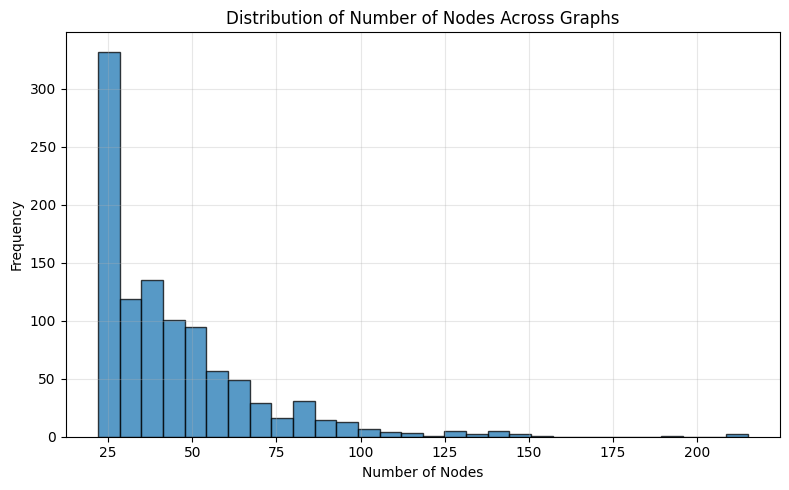

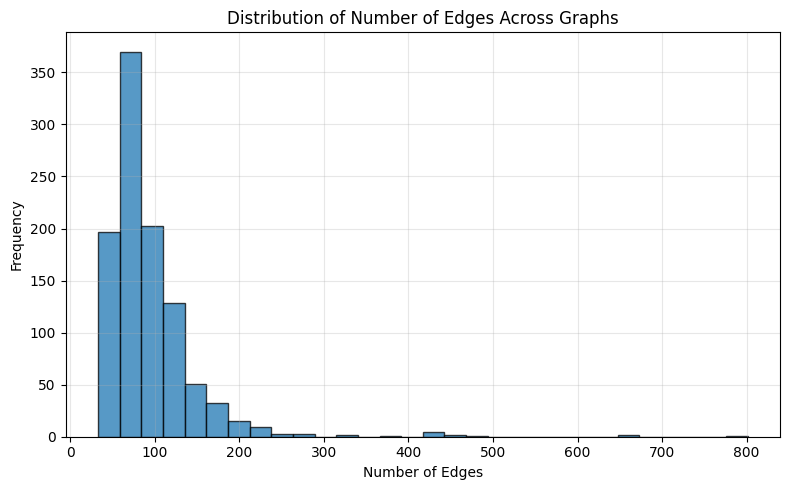

In [8]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx

# ----------------------------------------------------------
# Load your graphs
# ----------------------------------------------------------
graphs = pickle.load(open("synthetic_kegg_random_sized_graphs.dat", "rb"))

# ----------------------------------------------------------
# Extract number of nodes and edges
# ----------------------------------------------------------
node_counts = [G.number_of_nodes() for G in graphs]
edge_counts = [G.number_of_edges() for G in graphs]

# ----------------------------------------------------------
# Plot node distribution
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(node_counts, bins=30, alpha=0.75, edgecolor='black')
plt.title("Distribution of Number of Nodes Across Graphs")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Plot edge distribution
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(edge_counts, bins=30, alpha=0.75, edgecolor='black')
plt.title("Distribution of Number of Edges Across Graphs")
plt.xlabel("Number of Edges")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


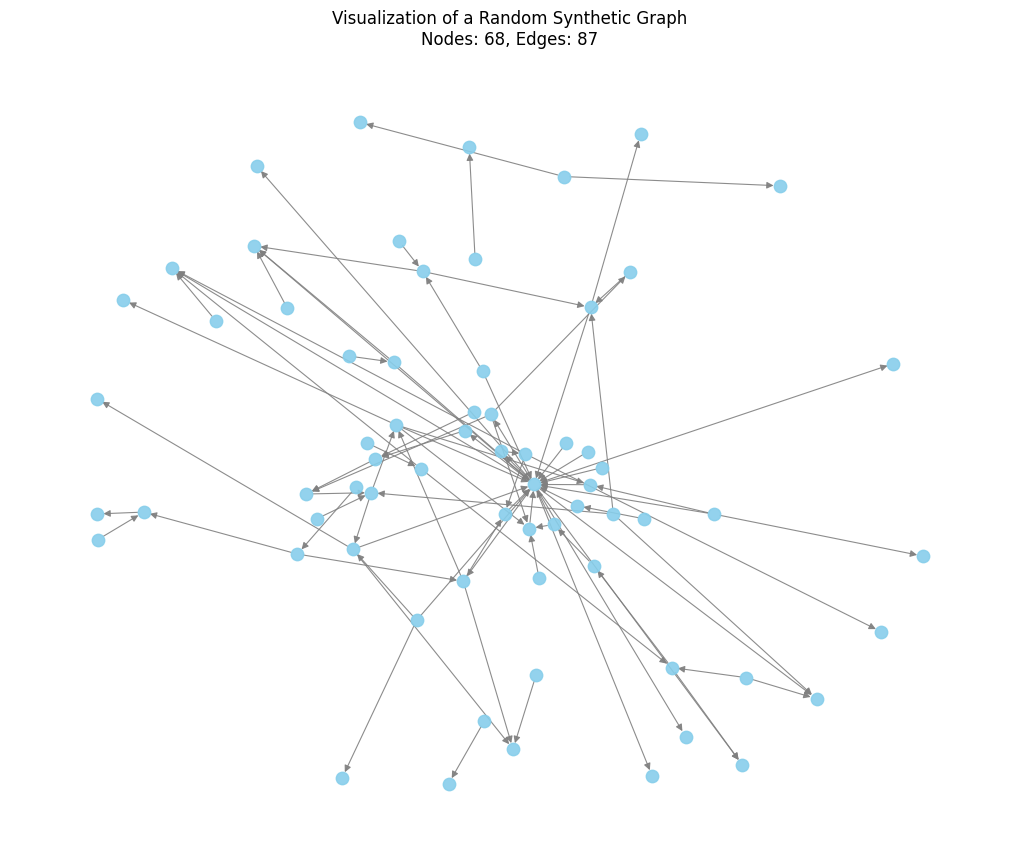

In [10]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import random

# ----------------------------------------------------------
# Load graphs
# ----------------------------------------------------------
graphs = pickle.load(open("synthetic_kegg_random_sized_graphs.dat", "rb"))

# ----------------------------------------------------------
# Pick one graph randomly
# ----------------------------------------------------------
G = random.choice(graphs)

# ----------------------------------------------------------
# Convert to undirected for nicer visualization
# (Directed edges make layouts messy)
# ----------------------------------------------------------
H = nx.DiGraph(G)   # keep original
U = nx.Graph(G)     # undirected copy for visualization

# ----------------------------------------------------------
# Draw the graph
# ----------------------------------------------------------
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(H, seed=42, k=0.2)  # spring layout for clarity

nx.draw(
    H, pos,
    node_size=80,
    node_color="skyblue",
    edge_color="gray",
    width=0.8,
    alpha=0.9
)

plt.title(f"Visualization of a Random Synthetic Graph\nNodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
plt.axis("off")
plt.show()
